# Computer Vision
This notebook includes some examples of techniques used to analyze images - which is a common requirement in AI solutions.

## Manipulating Images
As far as computers are concerned, images are simply numerical data representations. You can use statistical techniques to manipulate and analyze the numerical properties of images.

### Load an Image
Let's start by loading a JPG file and examining its properties. Run the following cell to load and display an image.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 10  125k   10 12971    0     0  22097      0  0:00:05 --:--:--  0:00:05 22097
100  125k  100  125k    0     0   190k      0 --:--:-- --:--:-- --:--:--  190k


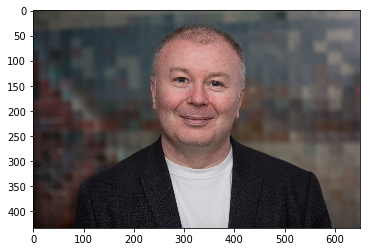

In [1]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
%matplotlib inline

!curl https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg -o img.jpg

i = np.array(Image.open('img.jpg'))
imshow(i)

### Examine Numerical Properties of the Image
You can clearly see that this is an image, but how does the computer interpret the data?

Run the cell below to determine the data type of the image.

In [3]:
type(i)

numpy.ndarray

The image data is actually stored as a multi-dimensional array.

Let's see what data type the array elements are:

In [4]:
i.dtype

dtype('uint8')

OK, so the array consists of 8-bit integer values. In other words, whole numbers between 0 and 255.

Now let's examine the shape of the array:

In [5]:
i.shape

(433, 650, 3)

So the image data is a three dimensional 433 x 650 x 3 array.

This is a RGB color JPG image sized 433 x 650 pixels. The image includes pixel values for red, green, and blue color channels. 

To keep things simple, let's convert the image to a greyscale image so we only have one color channel dimension to deal with:

(433, 650)

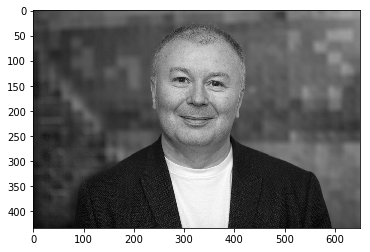

In [6]:
import skimage.color as sc

i_mono = sc.rgb2gray(i)
imshow(i_mono, cmap='gray')
i_mono.shape

### View Pixel Value Distributions
Let's look at the distribution of pixel values in the image. Ideally, the image should have relatively even distribution of values, indicating good contrast and making it easier to extract analytical information.

An easy way to check this is to plot a histogram.

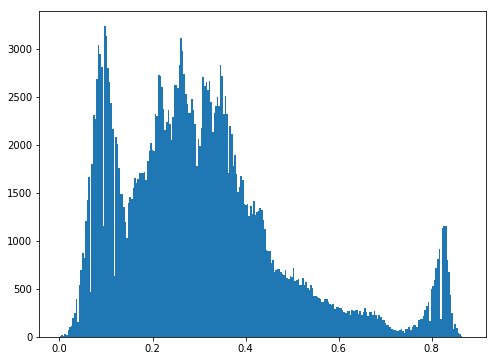

In [7]:
def im_hist(img):
    import matplotlib.pyplot as plt    
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()    
    ax.hist(img.flatten(), bins = 256)
    plt.show()

im_hist(i_mono)

Another useful way to visualize the statistics of an image is as a cumulative distribution function (CDF) plot. Ideally, this should result in a fairly straight diagonal line.

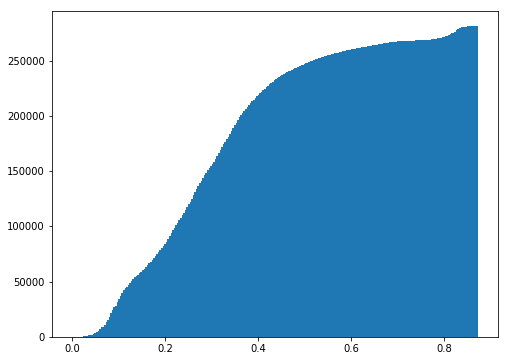

In [8]:
def im_cdf(img):
    import matplotlib.pyplot as plt    
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()    
    ax.hist(img.flatten(), bins = 256, cumulative=True)
    plt.show()
    
im_cdf(i_mono)

The histogram and CDF for our image show pretty uneven distribution. Ideally we should equalize the values in the image to improve its analytical value.

### Equalize the Image
Histogram equalization is often used to improve the statistics of images. In simple terms, the histogram equalization algorithm attempts to adjust the pixel values in the image to create a more uniform distribution. The code in the cell below uses the  **exposure.equalize_hist** method from the **skimage** package to equalize the image.  

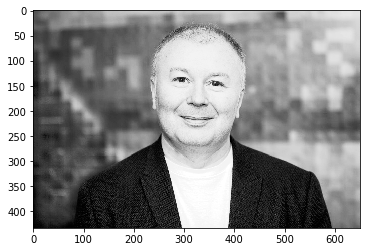

In [9]:
from skimage import exposure

i_eq = exposure.equalize_hist(i_mono)
imshow(i_eq, cmap='gray')

Now let's see what that's done to the histogram and CDF plots:

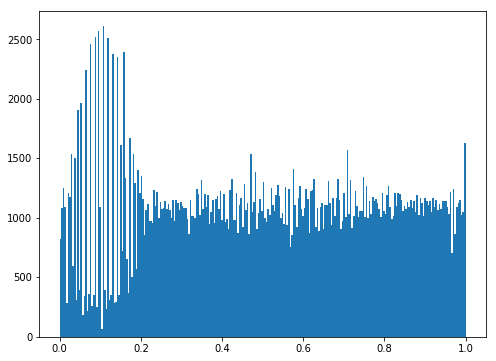

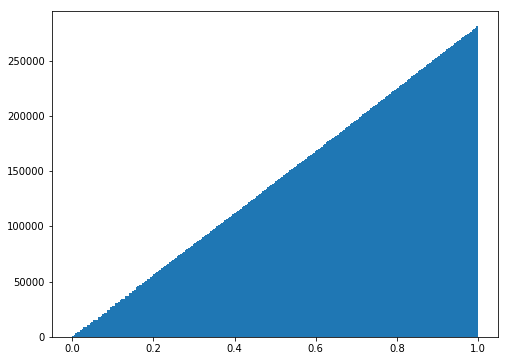

In [10]:
im_hist(i_eq)
im_cdf(i_eq)

The pixel intensities are more evenly distributed in the equalized image.

## Denoising with Filters

Often images need to be cleaned up to remove "salt and pepper" noise.

### Add Some Random Noise
Let's add some random noise to our image - such as you might see in a photograph taken in low light or at a low resolution.

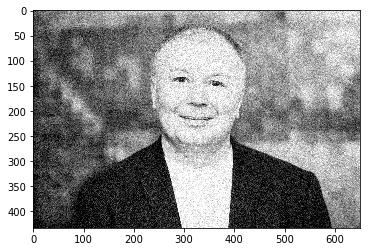

In [11]:
import skimage
i_n = skimage.util.random_noise(i_eq)
imshow(i_n, cmap="gray")

### Using a Gaussian Filter
A Gaussian filter applies a weighted average (mean) value for pixels based on the pixels that surround them.

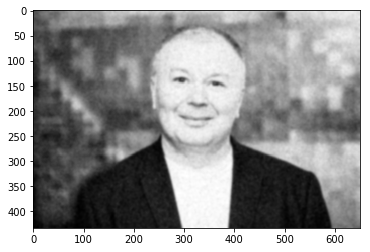

In [12]:
def gauss_filter(im, sigma = 2):
    from scipy.ndimage.filters import gaussian_filter as gf
    import numpy as np
    return gf(im, sigma = sigma)   
i_g = gauss_filter(i_n)
imshow(i_g, cmap="gray")

### Using a Median Filter
The Gaussian filter results in a blurred image - we could try a median filter, which as the name suggests applies the median value to pixels based on the pixels around them.

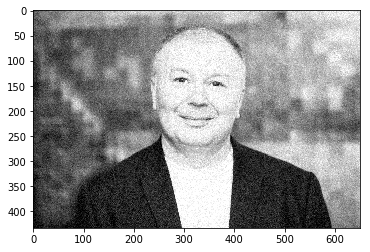

In [13]:
def med_filter(im, size = 2):
    from scipy.ndimage.filters import median_filter as mf
    import numpy as np
    return mf(im, size = size)     
i_m = med_filter(i_n)
imshow(i_m, cmap="gray")

### Extract Features
Now that we've done some initial processing of the image to improve its statistics for analysis, we can start to extract features from it.
#### Sobel Edge Detection
As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values. 

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

    1. Convert the color, rgb, image to grayscale (in this case, the image is already grayscale - but you should always do this because using a grayscale image simplifies the gradient calculation since it is two dimensional.
    2. Computer the gradient in the x and y (horizontal and vertical) directions. 
    3. Compute the magnitude of the gradient.
    4. Normalize the gradient values. 


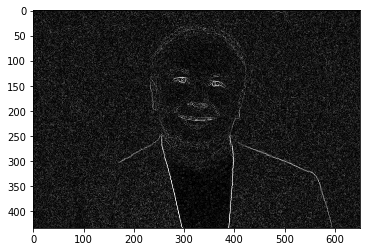

In [14]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

i_edge = edge_sobel(i_m)
imshow(i_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

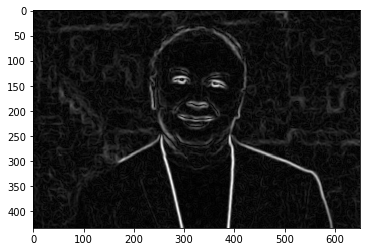

In [15]:
i_edge = edge_sobel(i_g)
imshow(i_edge, cmap="gray")

Note that the lines are more pronounced. Although a gaussian filter makes the image blurred to human eyes, this blurring can actually help accentuate contrasting features.

#### Harris Corner Detection
Another example of a feature extraction algorithm is corner detection. In simple terms, the Harris corner detection algorithm locates regions of the image with large changes in pixel values in all directions. These regions are said to be corners. The Harris corner detector is paired with the **corner_peaks** method. This operator filters the output of the Harris algorithm, over a patch of the image defined by the span of the filters, for the most likely corners.

[[142 291]
 [149 368]]


'Done'

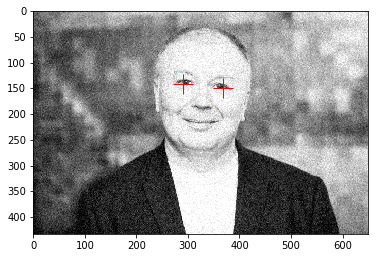

In [16]:
# Function to apply the Harris corner-detection algorithm to an image
def corner_harr(im, min_distance = 20):
    from skimage.feature import corner_harris, corner_peaks
    mag = corner_harris(im)
    return corner_peaks(mag, min_distance = min_distance)

# Find the corners in the median filtered image with a minimum distance of 20 pixels
harris = corner_harr(i_m, 20)

print (harris)

# Function to plot the image with the harris corners marked on it
def plot_harris(im, harris, markersize = 20, color = 'red'):
    import matplotlib.pyplot as plt
    import numpy as np
    fig = plt.figure(figsize=(6, 6))
    fig.clf()
    ax = fig.gca()    
    ax.imshow(np.array(im).astype(float), cmap="gray")
    ax.plot(harris[:, 1], harris[:, 0], 'r+', color = color, markersize=markersize)
    return 'Done'  

plot_harris(i_m, harris)

The corner detection algorithm has identified the eyes in the image.

## Using the Computer Vision API
The techniques used so far in this notebook show how you can perform simple image amnipulation and apply some popular algorithms to analyze images. More complex image analysis capabilities are encapsulated in the Computer Vision API cognitive service.

### Create a Computer Vision API Service
To provision a Computer Vision API service in your Azure subscription, Follow these steps:

1. Open another browser tab and navigate to https://portal.azure.com.
2. Sign in using your Microsoft account.
3. Click **+ New**, and in the **AI + Cognitive Services** category, click **See all**.
4. In the list of cognitive services, click **Computer Vision API**.
5. In the **Computer Vision API** blade, click **Create**.
6. In the **Create** blade, enter the following details, and then click **Create**
  * **Name**: A unique name for your service.
  * **Subscription**: Your Azure subscription.
  * **Location**: Choose the Azure datacenter location where you want to host your service.
  * **Pricing tier**: Choose the F0 pricing tier.
  * **Resource Group**: Choose the existing resource group you created in the previous lab (or create a new one if you didn't complete the previous lab)
  * Read the notice about the use of your data, and select the checkbox.
7. Wait for the service to be created.
8. When deployment is complete, click **All Resources** and then click your Computer Vision service to open its blade.
9. In the blade for your Computer Vision service, note the **Endpoint** URL. Then assign the base URI (*location*.api.cognitive.microsoft.com) for your service to the **visionURI** variable in the cell below.
10. In the blade for your Computer Vision service, click **Keys** and then copy **Key 1** to the clipboard and paste it into the **visionKey** variable assignment value in the cell below. 
11. Run the cell below to assign the variables.


In [21]:
visionURI = 'northeurope.api.cognitive.microsoft.com'
visionKey = '9850a1c589304d4db1e26b03057aa603'

### Get An Image from a URL
Let's start with the same image we analyzed previously.

Run the code in the cell below to retrieve the original color image from its URL:

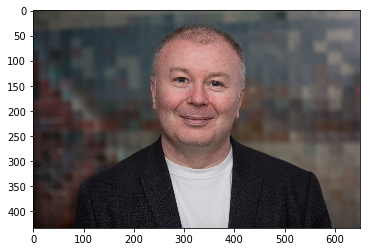

In [22]:
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import requests
from io import BytesIO

img_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg'

# Get the image and show it
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
imshow(img)

### Use the Computer Vision API to Get Image Features
The Computer Vision API uses a machine learning model that has been trtained with millions of images. It can extract features from images and return a suggested description, as well as details about the image file and a suggested list of "tags" that apply to it.

Run the cell below to see what caption the Computer Vision API suggests for the image above.

In [23]:
def get_image_features(img_url):
    import http.client, urllib.request, urllib.parse, urllib.error, base64, json

    headers = {
        # Request headers.
        'Content-Type': 'application/json',
        'Ocp-Apim-Subscription-Key': visionKey,
    }

    params = urllib.parse.urlencode({
        # Request parameters. All of them are optional.
        'visualFeatures': 'Categories,Description,Color',
        'language': 'en',
    })

    body = "{'url':'" + img_url + "'}"

    try:
        # Execute the REST API call and get the response.
        conn = http.client.HTTPSConnection(visionURI)
        conn.request("POST", "/vision/v1.0/analyze?%s" % params, body, headers)
        response = conn.getresponse()
        data = response.read()

        # 'data' contains the JSON response.
        parsed = json.loads(data.decode("UTF-8"))
        if response is not None:
            return parsed
        conn.close()


    except Exception as e:
        print('Error:')
        print(e)
        
jsonData = get_image_features(img_url)
desc = jsonData['description']['captions'][0]['text']
print(desc)

a man wearing a suit and tie smiling at the camera


The description is reasonably, if not exactly, appropriate.

Run the cell below to see the full JSON response, including image properties and suggested tags.

In [24]:
import json

# View the full details returned
print (json.dumps(jsonData, sort_keys=True, indent=2))

{
  "categories": [
    {
      "detail": {
        "celebrities": []
      },
      "name": "people_young",
      "score": 0.3828125
    }
  ],
  "color": {
    "accentColor": "884B43",
    "dominantColorBackground": "Grey",
    "dominantColorForeground": "Black",
    "dominantColors": [
      "Black",
      "Grey"
    ],
    "isBWImg": false,
    "isBwImg": false
  },
  "description": {
    "captions": [
      {
        "confidence": 0.9852349823983914,
        "text": "a man wearing a suit and tie smiling at the camera"
      }
    ],
    "tags": [
      "person",
      "man",
      "suit",
      "building",
      "necktie",
      "wearing",
      "smiling",
      "front",
      "posing",
      "jacket",
      "looking",
      "standing",
      "holding",
      "camera",
      "business",
      "glasses",
      "black",
      "older",
      "white",
      "old",
      "table",
      "brick",
      "red",
      "hat",
      "sign",
      "blue",
      "shirt"
    ]
  },
  "metadata":

Let's try with a different image:

a close up of a guitar


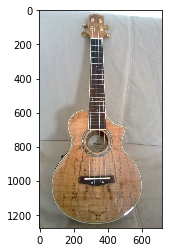

In [25]:
img_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/uke.jpg'

# Get the image and show it
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
imshow(img)
jsonData = get_image_features(img_url)
desc = jsonData['description']['captions'][0]['text']
print(desc)

How about something a little more complex?

a crowd of people watching a football game


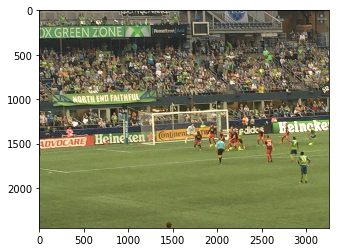

In [26]:
img_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/soccer.jpg'

# Get the image and show it
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
imshow(img)
jsonData = get_image_features(img_url)
desc = jsonData['description']['captions'][0]['text']
print(desc)

## Using the Face API
While the Computer Vision API is useful for general image analysis, the Face API offers specific functions for analyzing faces in images. This can be useful in a variety of AI scenarios.

### Create a Face API Service
To provision a Computer Vision API service in your Azure subscription, Follow these steps:

1. Open another browser tab and navigate to https://portal.azure.com.
2. Sign in using your Microsoft account.
3. Click **+ New**, and in the **AI + Cognitive Services** category, click **See all**.
4. In the list of cognitive services, click **Face**.
5. In the **Face** blade, click **Create**.
6. In the **Create** blade, enter the following details, and then click **Create**
  * **Name**: A unique name for your service.
  * **Subscription**: Your Azure subscription.
  * **Location**: Choose the Azure datacenter location where you want to host your service.
  * **Pricing tier**: Choose the F0 pricing tier.
  * **Resource Group**: Choose the existing resource group you created in the previous lab (or create a new one if you didn't complete the previous lab)
  * Read the notice about the use of your data, and select the checkbox.
7. Wait for the service to be created.
8. When deployment is complete, click **All Resources** and then click your Face service to open its blade.
9. In the blade for your Face service, copy the *full* **Endpoint** URL (including the *https* prefix and */face/v1.0/* path), and paste it into the **faceURI** variable assignment value in the cell below.
10. In the blade for your Face service, click **Keys** and then copy **Key 1** to the clipboard and paste it into the **faceKey** variable assignment value in the cell below. 
11. Run the cell below to assign the variables.

In [27]:
faceURI = "https://northeurope.api.cognitive.microsoft.com/face/v1.0"
faceKey = "473577dfabaf4c3ba1af2861a1fccbfc"

The Face API has a Python SDK, which you can install as a package. This makes it easier to work with.

Run the following cell to install the Face SDK.

In [28]:
!pip install cognitive_face

Now you're ready to use the Face API. First, let's see if we can detect a face in an image:

In [29]:
import cognitive_face as CF

# Set URI and Key
CF.BaseUrl.set(faceURI)
CF.Key.set(faceKey)


# Detect faces in an image
img_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme1.jpg'
result = CF.face.detect(img_url)
print (result)

[{'faceId': '53c9dea7-1cb4-48db-95c7-de723c27e1a4', 'faceRectangle': {'top': 258, 'left': 183, 'width': 321, 'height': 321}}]


The Face API has detected one face, and assigned it an ID. It also returns the coordinates for the top left corner and the width and height for the rectangle within which the face is detected.

Run the cell below to show the rectange on the image.

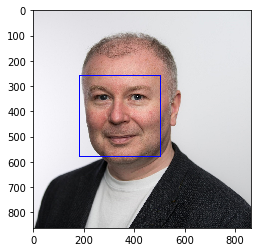

In [30]:
%matplotlib inline
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

# Get the image
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Add rectangles for each face found
color="blue"
if result is not None:
    draw = ImageDraw.Draw(img) 
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        left = faceRectangle['left']
        top = faceRectangle['top']
        width = faceRectangle['width']
        height = faceRectangle['height']
        draw.line([(left,top),(left+width,top)],fill=color, width=5)
        draw.line([(left+width,top),(left+width,top+height)],fill=color , width=5)
        draw.line([(left+width,top+height),(left, top+height)],fill=color , width=5)
        draw.line([(left,top+height),(left, top)],fill=color , width=5)

# show the image
imshow(img)


As well as detecting the face, the Face API assigned an ID to this face. The ID is retained by the service for a while, enabling you to reference it. Run the following cell to see the ID assigned to the face that has been detected:

In [31]:
face1 = result[0]['faceId']
print ("Face 1:" + face1)

Face 1:53c9dea7-1cb4-48db-95c7-de723c27e1a4


One useful thing you can do with the face ID is, is to use it to compare another image and see if a matching face is found. This kind of facial comparison is common in a variety of security / user authentication scenarios.

Let's try it with another image of the same person:

Face 2:94406663-f221-4802-91d8-24fad5712b92
Verified
Confidence Level: 0.91568


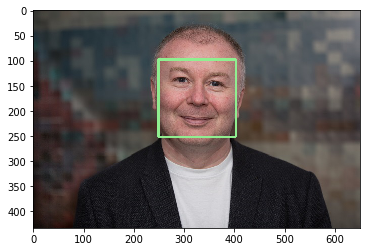

In [32]:
# Get the image to compare
img2_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
if result2 is not None:
    face2 = result2[0]['faceId']
    print ("Face 2:" + face2)

def verify_face(face1, face2):
    # By default, assume the match is unverified
    verified = "Not Verified"
    color="red"

    # compare the comparison face to the original one we retrieved previously
    verify = CF.face.verify(face1, face2)

    # if there's a match, set verified and change color to green
    if verify['isIdentical'] == True:
        verified = "Verified"
        color="lightgreen"

    # Display the second face with a red rectange if unverified, or green if verified
    draw = ImageDraw.Draw(img2) 
    for currFace in result2:
        faceRectangle = currFace['faceRectangle']
        left = faceRectangle['left']
        top = faceRectangle['top']
        width = faceRectangle['width']
        height = faceRectangle['height']
        draw.line([(left,top),(left+width,top)] , fill=color, width=5)
        draw.line([(left+width,top),(left+width,top+height)] , fill=color, width=5)
        draw.line([(left+width,top+height),(left, top+height)] , fill=color, width=5)
        draw.line([(left,top+height),(left, top)] , fill=color, width=5)

    # show the image
    imshow(img2)

    # Display verification status and confidence level
    print(verified)
    print ("Confidence Level: " + str(verify['confidence']))

verify_face(face1, face2)

The service has matched the face in a similar photo, with a reasonably high confidence level.

But what about the same face in a different photo - maybe with a stylish goatee beard and sunglasses?:

Face 2:055a72c9-7ab6-4001-8d56-d8bcde047f14
Verified
Confidence Level: 0.53324


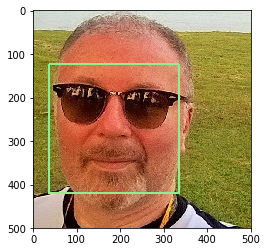

In [33]:
# Get the image to compare
img2_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme3.jpg'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
face2 = result2[0]['faceId']
print ("Face 2:" + face2)

verify_face(face1, face2)


Again, the face is matched - but with lower confidence reflecting the differences in the image.

What if we try to match the original face to a different person?

Face 2:13cd91dc-5193-4c47-b846-f558b136ad53
Not Verified
Confidence Level: 0.09689


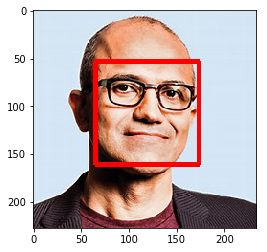

In [34]:
# Get the image to compare
img2_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/satya.jpg'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
face2 = result2[0]['faceId']
print ("Face 2:" + face2)

verify_face(face1, face2)


No match!

## Using the Custom Vision Cognitive Servive
The *Custom Vision* cognitive service enables you to create custom computer vision solutions.

In this notebook, you will create and train a Custom Vision *image classification* project that can identify pictures of apples and carrots, and use it to classify new images.

> **Note**: *Some of the images used in the lab are sourced from the free image library at <a href='http://www.pachd.com' target='_blank'>www.pachd.com</a>*

### Install the Custom Vision SDK
The first step is to install the Python SDK for the Custom Vision service:

In [35]:
# Install the Custom Vision SDK
! pip install azure-cognitiveservices-vision-customvision

Now lets download and extract the images you will use to train your classifier.

In [36]:
!curl https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/produce.zip -o produce.zip
!unzip produce.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 26.3M    0  1904    0     0   1258      0  6:06:18  0:00:01  6:06:17  1257
 47 26.3M   47 12.5M    0     0  5426k      0  0:00:04  0:00:02  0:00:02 5424k
100 26.3M  100 26.3M    0     0  8349k      0  0:00:03  0:00:03 --:--:-- 8349k
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Create a Custom Vision service instance
Now you're ready to use the Custom Vision service. You'll need to create an instance of the service and get your unique training and prediction keys so you can access it:
1. If you don't already have an Azure subscription, sign up for a free trial at https://azure.microsoft.com/Account/Free.
2. Go to https://customvision.ai/ and sign in using the Microsoft account associated with your Azure subscription.
3. Create a custom vision service in your subscription. Specify any available location, and select the **S0** pricing tier.
4. Click the *Settings* (&#9881;) icon at the top right to view your *training key* and *prediction key*. Then assign these to the variables below, change the location in the *endpoint* as necessary, and run the cell:

In [37]:
TRAINING_KEY = '32c6dacbf0814ef6bbda242a49288b0d'
PREDICTION_KEY = 'd81837def4d24e5797e1b3d7d3210483'
ENDPOINT='https://southcentralus.api.cognitive.microsoft.com' # Use just the base URL - https://<region>.api.cognitive.microsoft.com
PREDICTION_RESOURCE_ID="/subscriptions/505a8160-6cfe-4f27-99cf-e7c64119f965/resourceGroups/RenatevanKempen/providers/Microsoft.CognitiveServices/accounts/RenatevanKempen_prediction"

### Create a Custom Vision project
Now we'll create a project for the apple/carrot classifier:

In [38]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient

trainer = CustomVisionTrainingClient(TRAINING_KEY, endpoint=ENDPOINT)

# Create a new project
print ("Creating project...")
project = trainer.create_project("Produce Classification")
print("Created project!")

Creating project...
Created project!


### Add tags
The project will identify images as apples or carrots, so we'll need tags for those classes:

In [39]:
# Make two tags in the new project
print("Creating tags...")
apple_tag = trainer.create_tag(project.id, "Apple")
carrot_tag = trainer.create_tag(project.id, "Carrot")
print('Created tags!')

Creating tags...
Created tags!


### Upload training images
Now that we've got the tags, we need to upload some images of apples and carrots, assign the appropriate tags:

In [44]:
import os

print("Adding images...")

apples_dir = "Documents/MS Azure Data Science/AI Track/Lab03/apples"
for image in os.listdir(apples_dir):
    with open(os.path.join(apples_dir, image), mode="rb") as img_data: 
        trainer.create_images_from_data(project.id, img_data.read(), [apple_tag.id])

carrots_dir = "Documents/MS Azure Data Science/AI Track/Lab03/carrots"
for image in os.listdir(carrots_dir):
    with open(os.path.join(carrots_dir, image), mode="rb") as img_data: 
        trainer.create_images_from_data(project.id, img_data.read(), [carrot_tag.id])
        
print('Added images!')

Adding images...
Added images!


Return to your Custom Vision service and click the *Home* (&#8962;) icon to return to the home page, and then open the ***Apple or Carrot*** project to view the images that have been uploaded and tagged.

### Train the project
With the tagged images in place, we're now ready to train a classification model:

In [45]:
import time

print ("Training...")
# Train the project, checking status every 1 second
iteration = trainer.train_project(project.id)
while (iteration.status == "Training"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)

# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, "First Iteration", PREDICTION_RESOURCE_ID)

# Make it the default iteration
iteration = trainer.update_iteration(project_id= project.id, iteration_id=iteration.id, name= "First Iteration", is_default=True)

print ("Trained!")

Training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Trained!


Return to your Custom Vision service and click the **Performance** tab to view the *Precision* and *Recall* metrics for your trained project. These should be pretty high, even through we only used a few images.

### Use the project to classify images
Now that we have a trained project, we can use it to predict the class of new images that weren't in the training dataset:

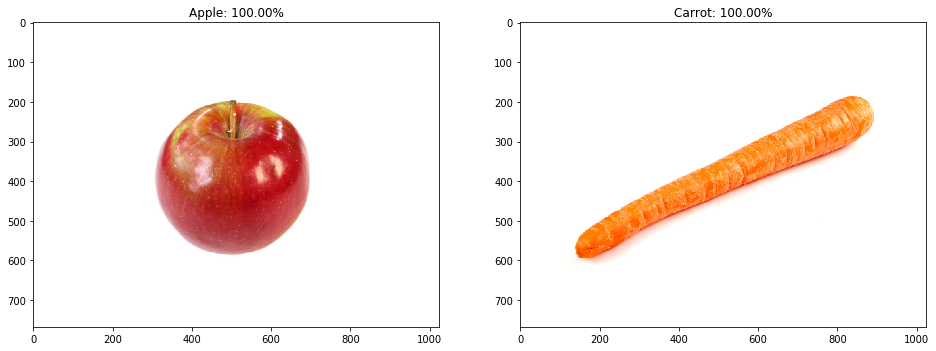

In [46]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

# Use two test images
test_img1_url = 'http://www.pachd.com/free-images/food-images/apple-01.jpg'
test_img2_url = 'http://www.pachd.com/free-images/food-images/carrot-02.jpg'

test_image_urls = []
test_image_urls.append(test_img1_url)
test_image_urls.append(test_img2_url)

# Create an instance of the prediction service
predictor = CustomVisionPredictionClient(PREDICTION_KEY, endpoint=ENDPOINT)

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Get the images and show the predicted classes
for url_idx in range(len(test_image_urls)):
    response = requests.get(test_image_urls[url_idx])
    image_contents = Image.open(BytesIO(response.content))
    results = predictor.classify_image_url(project_id=project.id, published_name=iteration.name, url=test_image_urls[url_idx])
    # The results include a prediction for each tag, in descending order of probability - so we'll get the first one
    prediction = results.predictions[0].tag_name + ": {0:.2f}%".format(results.predictions[0].probability * 100)
    # Subplot for image and its predicted class
    a=fig.add_subplot(1,2,url_idx+1)
    imgplot = plt.imshow(image_contents)
    a.set_title(prediction)

plt.show()